# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [5]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True).set_index('id')
profile = pd.read_json('data/profile.json', orient='records', lines=True).set_index('id')
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [83]:
portfolio.shape[0]

10

In [84]:
portfolio

,reward,channels,difficulty,duration,offer_type
id,,,,,
ae264e3637204a6fb9bb56bc8210ddfd,10,"[email, mobile, social]",10,7,bogo
4d5c57ea9a6940dd891ad53e9dbe8da0,10,"[web, email, mobile, social]",10,5,bogo
3f207df678b143eea3cee63160fa8bed,0,"[web, email, mobile]",0,4,informational
9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,7,bogo
0b1e1539f2cc45b7b9fa7c272da2e1d7,5,"[web, email]",20,10,discount
2298d6c36e964ae4a3e7e9706d1fb8c2,3,"[web, email, mobile, social]",7,7,discount
fafdcd668e3743c1bb461111dcafc2a4,2,"[web, email, mobile, social]",10,10,discount
5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,3,informational
f19421c1d4aa40978ebb69ca19b0e20d,5,"[web, email, mobile, social]",5,5,bogo


(array([1308., 1438., 2054., 3383., 3257., 2031.,  966.,  361.,   27.,
        2175.]),
 array([ 18.,  28.,  38.,  48.,  58.,  68.,  78.,  88.,  98., 108., 118.]),
 <BarContainer object of 10 artists>)

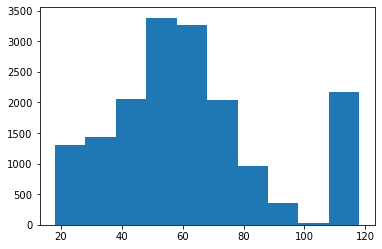

In [58]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.hist(profile.age, bins=10)

In [47]:
unidentified = profile[profile.age > 102].copy()
unidentified.age.value_counts()

118    2175
Name: age, dtype: int64

In [18]:
print("Gender")
print(unidentified.gender.value_counts())
print("Income")
print(unidentified.income.value_counts())
print("Join Date")
print(unidentified.became_member_on.value_counts())

Gender
Series([], Name: gender, dtype: int64)
Income
Series([], Name: income, dtype: int64)
Join Date
20170901    11
20171002     9
20170928     8
20171126     8
20170907     8
            ..
20160625     1
20160122     1
20140205     1
20160701     1
20160512     1
Name: became_member_on, Length: 950, dtype: int64


In [27]:
print("Unidentified Length")
print(unidentified.shape[0])
print(profile.shape[0])
print("Missing Percent: " + str(round(unidentified.shape[0]/profile.shape[0] * 100, 2)))

Unidentified Length
2175
17000
Missing Percent: 12.79


### Comment
We see that for significant portion of the data the individual is missing all data except for when they became a member

In [116]:
# verify that people with valid age have other fields as valid
have_valid_age = profile[profile.age <= 102]
have_valid_age.isna().sum()

gender              0
age                 0
became_member_on    0
income              0
dtype: int64

### Comment
Indeed we see all such people have all fields 

In [117]:
identified = have_valid_age.copy()
have_valid_age = None

In [51]:
unidentified['became_member_on'] = pd.to_datetime(unidentified['became_member_on'], format="%Y%m%d")
identified['became_member_on'] = pd.to_datetime(identified['became_member_on'], format="%Y%m%d")

In [57]:
fig, ax = plt.subplots()
ax.plot(identified.groupby('became_member_on').count().iloc[:, 0]

became_member_on
2013-07-29     1
2013-07-30     3
2013-07-31     1
2013-08-01     1
2013-08-02     2
              ..
2018-07-22    22
2018-07-23     8
2018-07-24    17
2018-07-25    15
2018-07-26    21
Name: gender, Length: 1707, dtype: int64

Text(0.5, 1.0, 'Join Date All Data')

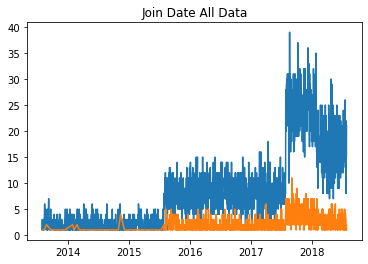

In [74]:
fig, ax = plt.subplots()
years_fmt = mdates.DateFormatter('%Y')
join_date_counts_identified = identified.groupby('became_member_on').count()
join_date_counts_unidentified = unidentified.groupby('became_member_on').count()            
ax.xaxis.set_major_formatter(years_fmt)
ax.plot(join_date_counts_identified.index, join_date_counts_identified.age)
ax.plot(join_date_counts_unidentified.index, join_date_counts_unidentified.age)
ax.set_title("Join Date All Data")

Text(0.5, 1.0, 'Join Date, idenfitied people 2017')

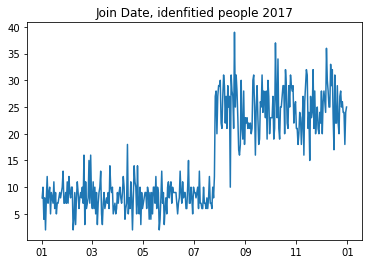

In [76]:
# lots of noise/variation in above data -- is it seasonal? subset to one year
join_date_counts_identified_2017 = join_date_counts_identified.loc[
    (join_date_counts_identified.index >= pd.to_datetime("2017/01/01")) & 
    (join_date_counts_identified.index < pd.to_datetime("2018/01/01"))]
fig, ax = plt.subplots()
month_fmt = mdates.DateFormatter('%m')
ax.xaxis.set_major_formatter(month_fmt)
ax.plot(join_date_counts_identified_2017.index, join_date_counts_identified_2017.age)
ax.set_title("Join Date, idenfitied people 2017")

### Comment 
The number of people who joined seems to have noise, with a upward trend. 
If in the future we want to use it lets note we may want to smooth join date. 


In [77]:
identified_transcript = pd.merge(identified, transcript, left_on = 'id', right_on='person', validate='one_to_many')
unidentified_transcript = pd.merge(unidentified, transcript, left_on = 'id', right_on='person', validate='one_to_many')
profile_transcript = pd.merge(profile, transcript, left_on = 'id', right_on='person', validate='one_to_many')

In [80]:
print('Length of transcript for identified people = ' + str(identified_transcript.shape[0]))
print('Length of transcript for unidentified people = ' + str(unidentified_transcript.shape[0]))
print('Percent transcripts for unidentified people = ' + 
      str(unidentified_transcript.shape[0] / (profile_transcript.shape[0]) * 100))

Length of transcript for identified people = 272762
Length of transcript for unidentified people = 33772
Percent transcripts for unidentified people = 11.017374907840566


In [81]:
portfolio.offer_type.value_counts()

bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64

Text(0, 0.5, 'Number of People')

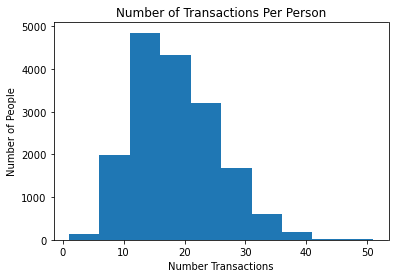

In [99]:
plt.hist(profile_transcript.groupby('person').count().age, bins=10)
plt.title("Number of Transactions Per Person")
plt.xlabel("Number Transactions")
plt.ylabel("Number of People")

In [113]:
from sklearn.cluster import KMeans
from sklearn import preprocessing
def kmeans_elbow(df, scale=True):
    minmax_scaler = preprocessing.MinMaxScaler()
    scaled_df = minmax_scaler.fit_transform(df)
    wss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
        kmeans.fit(scaled_df)
        wss.append(kmeans.inertia_)
    fig = plt.figure(figsize=(8, 8))
    plt.plot(range(1, 11), wss)
    plt.title('The Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WSS')
    plt.show()

In [108]:
identified.head()

,gender,age,became_member_on,income
id,,,,
0610b486422d4921ae7d2bf64640c50b,F,55,2017-07-15,112000.0
78afa995795e4d85b5d9ceeca43f5fef,F,75,2017-05-09,100000.0
e2127556f4f64592b11af22de27a7932,M,68,2018-04-26,70000.0
389bc3fa690240e798340f5a15918d5c,M,65,2018-02-09,53000.0
2eeac8d8feae4a8cad5a6af0499a211d,M,58,2017-11-11,51000.0


In [110]:
def convert_gender(series, conv_dict):
    series = series.apply(lambda x: conv_dict[x])
    return series

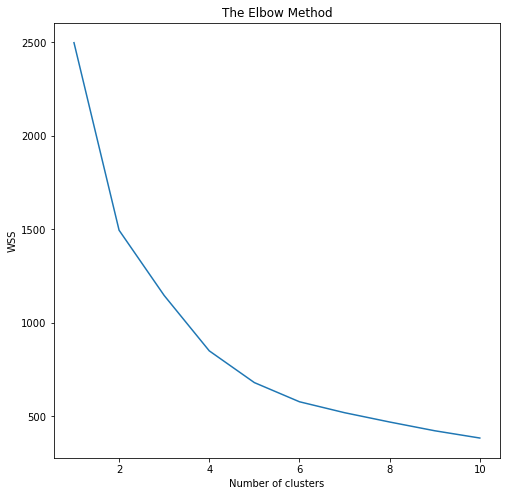

In [118]:
identified['gender'] = convert_gender(identified.gender, {'F': 0, 'M': 1, 'O': 2})
kmeans_elbow(identified[["gender", "age", "income"]])

In [ ]:
# 4 categories seem reasonable, lets see what they look like
# do this later, i don't think it will be super useful - will circle back

In [121]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [291]:
# modify trascript to include when transactions were in an offer period had been viewed
# this value will indicate wether the transaction in question happened due to a running offer.
def transaction_state(df, impression_colname, impression_source_colname):
    """ input
      df: transcript dataframe, has information on when users transacted and when they received offers
      colname: name of new column that will have impression - transaction or not and if so is it because of offer   
    """
    
    customer_ids = set(df.person.values)
    impression = {}
    source = {}
    # iterate over all customers
    for customer in customer_ids:
        customer_transcript = df[df.person == customer]

        received_offer = {}
        active_dict = {}
        max_active_end = 0 # the end time of the event that is ending the latest
        cur_max_offer_id = "" # id of the offer with max active end
        for index, row in customer_transcript.iterrows():
            time = row['time']
            # eliminate adverts not active from active_dict
            for key in list(active_dict.keys()):
                if active_dict[key] < time:
                    del active_dict[key]
            
            # if new offer, record when it will expire in received_offer
            if row['event'] == "offer received":
                new_event_end = row['time'] + portfolio.loc[
                    row['value']['offer id'] == portfolio.index]['duration'].values[0] * 24
                received_offer[row['value']['offer id']] = new_event_end
            
            # after viewing an offer we add it to the active_dict and possibly update the time until all transactions
            # will be flagged as being due to an offer
            if row['event'] == "offer viewed":
                # error in data if element not in dict (viewed an offer that hasn't been received)
                new_event_end = received_offer[row['value']['offer id']]
                active_dict[row['value']['offer id']] = new_event_end
                if new_event_end > max_active_end:
                    max_active_end = new_event_end
                    cur_max_offer_id = row['value']['offer id']
                    
            if row['event'] == 'offer completed':
                offer_id = row['value']['offer_id']
                # an unviewed offer could be completed
                active_dict.pop(offer_id, None)
                if offer_id == cur_max_offer_id:
                    # find next offer with highest end date
                    new_max_active_end = 0
                    new_max_offer_id = ""
                    for key, value in active_dict.items():
                        if value > new_max_active_end:
                            new_max_active_end = value
                            new_max_offer_id = key
                    max_active_end = new_max_active_end
                    new_max_offer_id = new_max_offer_id

            # assign values in new col dict
            if row['event'] == 'transaction':
                if time <= max_active_end:
                    impression[index] = 1
                else:
                    impression[index] = 0
                this_source = []
                for key, value in active_dict.items():
                    this_source.append(key)
                source[index] = this_source
            else:
                impression[index] = -1
                source[index] = []
    df = df.copy()
    df[impression_colname] = pd.Series(impression)
    df[impression_source_colname] = pd.Series(source)
    return df

In [298]:
impressions_df = transaction_state(transcript, 'because_of_offer', 'impression_source')

In [296]:
# test the transaction state method. 

test1 = transcript.loc[transcript.person == "78afa995795e4d85b5d9ceeca43f5fef"]
test1_return = transaction_state(test1, 'because_of_offer', 'impression_source')
test1_expected = {0: -1, 15561: -1, 47582: 1, 47583: -1, 49502: 0, 53176: -1, 85291: -1, 87134: 1, 
                 92104: 1, 141566: 0, 150598: -1, 163375: -1, 201572: -1, 218393: 1, 218394: -1, 
                 218395: -1, 230412: 0, 262138: -1}
test1_expected_source = {0: [], 15561: [], 47582: ['9b98b8c7a33c4b65b9aebfe6a799e6d9'], 47583: [], 49502: [],
                         53176: [], 85291: [], 87134: ['5a8bc65990b245e5a138643cd4eb9837'],  
                         92104: ['5a8bc65990b245e5a138643cd4eb9837'], 141566: [], 150598: [], 163375: [], 
                         201572: [], 218393: ['ae264e3637204a6fb9bb56bc8210ddfd'], 218394: [], 218395: [], 
                         230412: [], 262138: []}

assert((test1_return.because_of_offer == pd.Series(test1_expected)).all())
assert((test1_return.impression_source == pd.Series(test1_expected_source)).all())

test2 =  transcript.loc[transcript.person == "2e87ba0fba1a4d1a8614af771f07a94d"]
test2_return = transaction_state(test2, 'because_of_offer', 'impression_source')
test2_expected = {45: -1, 24223: -1, 31109: 1, 31110: -1, 42034: 0, 53222: -1, 65856: -1, 65857: 1, 
                 65858: -1, 74812: 0, 106958: 0, 110873: -1, 123553: -1, 135232: 1, 135233: -1, 
                 143579: 0, 150644: -1, 163387: -1, 174370: 1, 174371: -1, 187146: 0, 201615: -1,
                 221912: -1, 232884: 1, 235177: 1, 300661: 0}
assert((test2_return.because_of_offer == pd.Series(test2_expected)).all())
print("tests passed")

tests passed


In [310]:
impressions_df.to_csv("data/impressions.csv")
identified.to_csv("data/identified.csv")
impressions_df.tail()

,person,event,value,time,because_of_offer,impression_source
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714,0,[]
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714,0,[]
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714,0,[]
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714,1,[9b98b8c7a33c4b65b9aebfe6a799e6d9]
306533,c02b10e8752c4d8e9b73f918558531f7,transaction,{'amount': 4.05},714,0,[]


### Thoughts
1. Impressions seem to follow a pattern. Person gets offer, views offer, transaction, offer completed. Transaction without offer. Perhaps there is a ordered aspect to this - potential social engineering eventually?
2. We have some way to say if a transaction was due to an offer. That is the user viewes the offer then within the offer period makes a transaction. We also have information about the user and the type of offer

    a. Can we predict if a user will respond to an offer
        i. additional features include how long they have been a member of starbucks
        ii. have the viewed offers in the past
        iii. To see if they bought because of offer, we could see if their buying patterns in offers is
            different than buying patterns when not in offer. For example did the spend a statistically significant
            amount of more money when in offer
    b. Can we predict if a user will predict to a specific offer
        i. here we would also add information about the offer

3. Does it matter that they converted an offer to a discount (completed). No. If they viewed an offer and their behavior
    during that time is statistically different than their behavior when they don't have an offer. Wheter they convert offers to discounts is irrelevant. 

In [301]:
# see distribution of transactions overall when in offer and when not in offer
transactions_df = impressions_df.loc[impressions_df['because_of_offer'] > -1].copy()
transactions_df['value'] = transactions_df['value'].apply(lambda x: x['amount'])

In [302]:
transactions_df.describe()

,value,time,because_of_offer
count,138953.000000,138953.000000,138953.000000
mean,12.777356,381.584334,0.518564
std,30.250529,201.697230,0.499657
min,0.050000,0.000000,0.000000
25%,2.780000,210.000000,0.000000
50%,8.890000,402.000000,1.000000
75%,18.070000,552.000000,1.000000
max,1062.280000,714.000000,1.000000


In [303]:
%matplotlib notebook

<IPython.core.display.Javascript object>


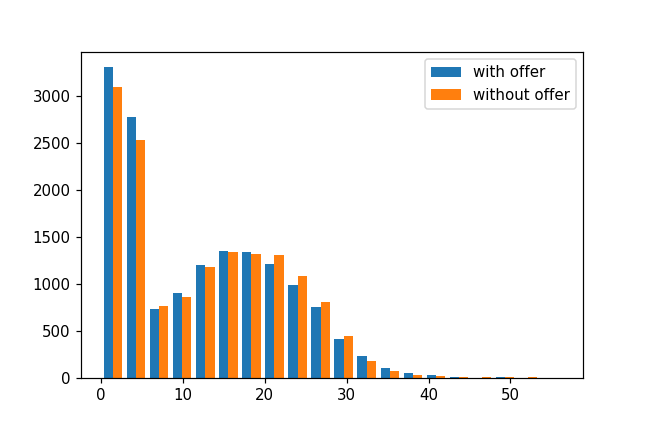

In [304]:
without_offer = transactions_df[transactions_df.because_of_offer == 0]
without_offer_mean = without_offer.groupby('person').mean()
with_offer = transactions_df[transactions_df.because_of_offer == 1]
with_offer_mean = with_offer.groupby('person').mean()

# eliminate upper outliers
from scipy import stats
with_offer_mean = with_offer_mean[stats.zscore(with_offer_mean.value) < 2]
without_offer_mean = without_offer_mean[stats.zscore(without_offer_mean.value) < 2]

fig, ax = plt.subplots()
ax.hist([with_offer_mean.value.values, without_offer_mean.value.values], bins=20, 
        label=['with offer', 'without offer'])
ax.legend()

<IPython.core.display.Javascript object>


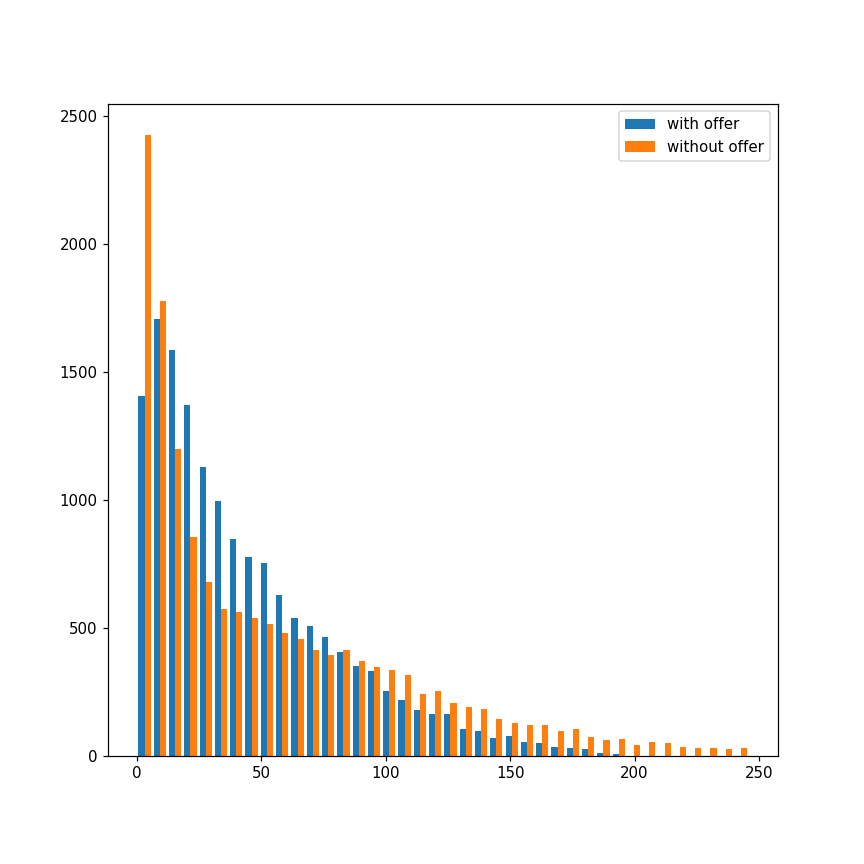

In [305]:
without_offer_sum = without_offer.groupby('person').sum(1)
with_offer_sum = with_offer.groupby('person').sum(1)

with_offer_sum = with_offer_sum[stats.zscore(with_offer_sum.value) < 2]
without_offer_sum = without_offer_sum[stats.zscore(without_offer_sum.value) < 2]

fig, ax = plt.subplots(figsize=(8,8))
ax.hist([with_offer_sum.value.values, without_offer_sum.value.values], bins=40, 
        label=['with offer', 'without offer'])
ax.legend()

<IPython.core.display.Javascript object>


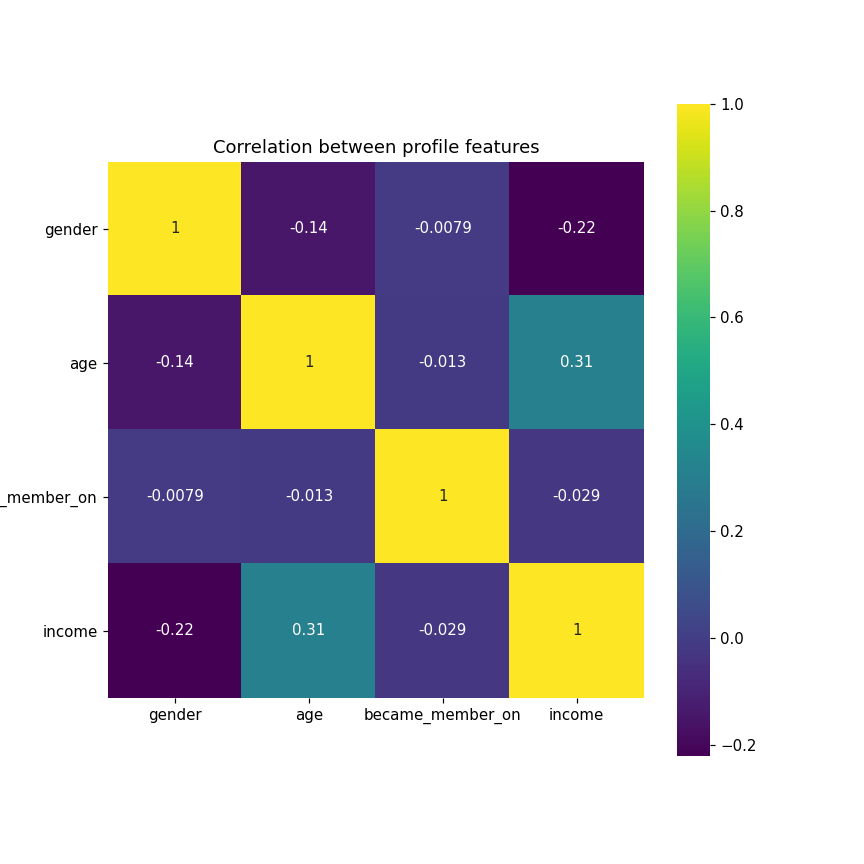

Text(0.5, 1.0, 'Correlation between profile features')

In [314]:
# lets see if we can combine the with and without offer
import seaborn as sns

correlation = identified.corr()
plt.figure(figsize=(8,8))
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='viridis')

plt.title('Correlation between profile features')

In [351]:
# verify each promotion is given to a given any individual exactly once
transcript_received = transcript[transcript['event'] == 'offer received'].copy()
transcript_received['value'] = transcript_received.value.apply(lambda x: x['offer id'])
customer_ids = set(transcript_received.person.values)
not_unique = []
for customer in customer_ids:
    person_received = transcript_received[transcript_received['person'] == customer]
    if not person_received.value.is_unique:
        not_unique.append(customer)
        
not_unique
# iterate over transcript
# find the promotions given to a person
# .... this means getting only received
# run unique on them

['dbb778dbe0924f56a54aa714406bbcd9',
 'd685d759e77b4795957052e318faf91d',
 '106c1ac833bc4bf7a9a8a1bf22340cac',
 'eb2aac9003d7475ba172d7328ad6ed38',
 '4e5923e5deab4d5cb1624a0b1cc9909c',
 '055a2a48b6f84b5ba3427e05e6beeb3f',
 'dcd1cd7325824551abff5eab7f97a0fe',
 'cbe87ab8d5ef41cb9a986196bdcb653f',
 '67fc25500b6b42fd923318fea3c136cb',
 '65daaf0f413744789903a355d6370b9d',
 '2d4eaf25aa8f45ffbbcebcce5082cad2',
 '555be575c91041cbaa47eb24744cc724',
 '5bfbf2afd12c4f49931e100c26506855',
 '45f2ec3384a8485c83d874637fd14852',
 '157bb920966e4ec5a9d4bf5b533a47f2',
 'bdec2c54b54a4033a8734aee6ae1cd01',
 '7a26250ec6ff4941a7415e1366b6fb3c',
 '787aa7b9aba44503b587ad158bd80627',
 '0b8503be108149b58bdd5f1827612fdc',
 '3c8d541112a74af99e88abbd0692f00e',
 '7a30763c05734cb3bd14123e1b6b9d63',
 'f164f2cddf3b4101aaac8115d65e5041',
 '6d7d772a795641ceb849c9cf357b4958',
 'ddfbe7c4575147e888beb1dc64fcd478',
 '94c9461e773e45a5be036e674bd6e201',
 'd0e37ab86e2a46df9674c6b80e80ab8c',
 '9c3f4f9d23d04636920cfe024b05eb6d',
 

In [356]:
print("People receiving same offer multiple time " + str(len(not_unique)))
print("total people " + str(len(profile)))

People receiving same offer multiple time 9986
total people 17000


In [659]:
def merge_intervals(lst):
    """ O(nlogn) merge of intervals, where lst is an array of 2 element tuples/lists
    giving the start and end time of intervals    
    """
    # O(nlogn) source
    lst.sort(key = lambda x: x[0])  
    merged = []
    i = 0
    while i < len(lst):
        j = i+1
        max_end = lst[i][1]
        while j < len(lst) and lst[j][0] <= max_end:
            if lst[j][1] > max_end:
                max_end = lst[j][1]
            j += 1
        merged.append([lst[i][0], max_end])
        i = j
    
    return merged

In [658]:
test1_merged = [[1, 4], [2, 6], [5, 10]]
expected1 = [[1, 10]]
assert(merge_intervals(test1_merged) == expected1)

test2_merged = []
expected2 = []
assert(merge_intervals(test2_merged) == expected2)

test3_merged = [[1, 4], [5, 10], [9, 12]]
expected3 = [[1, 4], [5, 12]]
assert(merge_intervals(test3_merged) == expected3)
print("test passed")

test passed


In [469]:
def sum_intervals(lst):
    """ O(n) dum of intervals, where lst is an array of 2 element tuples/lists
    giving the start and end time of intervals that are non-overlapping
    (assuming intent is to get total time in intervals)
    """
    total = 0
    for interval in lst:
        total += interval[1] - interval[0]
    return total

In [470]:
test1_merged = [[1, 10]]
expected1 = 9
assert(sum_intervals(test1_merged) == expected1)

test2_merged = []
expected2 = 0
assert(sum_intervals(test2_merged) == expected2)

test3_merged = [[1, 4], [5, 12]]
expected3 = 10
assert(sum_intervals(test3_merged) == expected3)
print("test passed")

test passed


In [668]:
def in_promotion_states(df):
    customer_ids = set(df.person.values)
    percent_days_promotion_viewed = {}
    percent_days_promotion_received = {}
    total_days = {}
    # iterate over all customers and create intervals of received/viewed
    for customer in customer_ids:
        customer_transcript = df[df.person == customer]
        
        # first entry
        time_start = 0
        # flag a first has been found
        first = False
        last_day = 0
        
        id_iter = 1
        viewed_interval = {}
        received_interval = {}
        offer_id_unviewed = {}
        offer_id_uncomp = {}
        for index, row in customer_transcript.iterrows():
            if not first and row['event'] != 'offer completed':
                time_start = row['time']
                first = True
                
            if row['event'] == 'offer received':
                time_till_effective = row['time'] + portfolio.loc[
                    row['value']['offer id'] == portfolio.index]['duration'].values[0] * 24
                received_interval[id_iter] = [row['time'], time_till_effective]
                if not row['value']['offer id'] in offer_id_unviewed:
                    offer_id_unviewed[row['value']['offer id']] = [id_iter]
                    offer_id_uncomp[row['value']['offer id']] = [id_iter]
                else:
                    offer_id_unviewed[row['value']['offer id']].append(id_iter)
                    offer_id_uncomp[row['value']['offer id']].append(id_iter)
                id_iter += 1
            
            if row['event'] == 'offer viewed':
                this_id = offer_id_unviewed[row['value']['offer id']].pop(0)
                # incase viewed after exipiry/completion
                if received_interval[this_id][1] > row['time']:
                    viewed_interval[this_id] = [row['time'], received_interval[this_id][1]]

            if row['event'] == 'offer completed':
                this_id = offer_id_uncomp[row['value']['offer_id']].pop(0)
                while received_interval[this_id][1] < row['time']:
                    this_id = offer_id_uncomp[row['value']['offer_id']].pop(0)
                # of completed, must have been received
                received_interval[this_id][1] = row['time']
                if this_id in viewed_interval:
                    viewed_interval[this_id][1] = row['time']
            
            if row['event'] == 'transaction':
                last_day = row['time']
        
        viewes_merged = merge_intervals(list(viewed_interval.values()))
        received_merged = merge_intervals(list(received_interval.values()))
        
        # compute total number of days of data
        max_viewes = 0
        if len(viewes_merged) > 0:
            max_viewes = viewes_merged[-1][1]
        max_received = 0
        if len(received_merged) > 0:
            max_received = received_merged[-1][1]
        last_day = max(max_viewes, max_received, last_day)
        
        # assign values, max because single valued customers exist
        total_days[customer] = max(last_day - time_start, 1)

        percent_days_promotion_viewed[customer] = sum_intervals(viewes_merged) / total_days[customer]
        percent_days_promotion_received[customer] = sum_intervals(received_merged) / total_days[customer]
    
    return pd.concat([pd.Series(total_days, name='total_days'), 
                      pd.Series(percent_days_promotion_viewed, name="promotion_viewed"), 
                      pd.Series(percent_days_promotion_received, name="promotion_received")], axis=1)

In [669]:
test1 = transcript[transcript.person == '78afa995795e4d85b5d9ceeca43f5fef']
test1_expected = {'total_days': 534, 'promotion_viewed': 0.47191 , 'promotion_received': 0.573034}
received1 = in_promotion_stats(test1)
assert(received1.total_days.values[0] == test1_expected['total_days'])
assert(round(received1.promotion_viewed.values[0], 4) == round(test1_expected['promotion_viewed'], 4))
assert(round(received1.promotion_received.values[0], 4) == round(test1_expected['promotion_received'], 4))

test2 = transcript[transcript.person == 'e5c59811346840e2ab81bd05303c3ebc']
test2_expected = {'total_days': 618, 'promotion_viewed': 0.378641, 'promotion_received': 0.436893}
received2 = in_promotion_states(test2)
assert(received2.total_days.values[0] == test2_expected['total_days'])
assert(round(received2.promotion_viewed.values[0], 4) == round(test2_expected['promotion_viewed'], 4))
assert(round(received2.promotion_received.values[0], 4) == round(test2_expected['promotion_received'], 4))

print('test passed')

test passed


In [670]:
promotion_exposure = in_promotion_states(transcript)

In [671]:
promotion_exposure.to_csv("promotion_exposure.csv")
promotion_exposure.describe()

,total_days,promotion_viewed,promotion_received
count,17000.000000,17000.000000,17000.000000
mean,655.083588,0.340576,0.615199
std,95.008029,0.225620,0.224740
min,1.000000,0.000000,0.000000
25%,612.000000,0.160714,0.446602
50%,672.000000,0.309091,0.622222
75%,708.000000,0.491935,0.791667
max,816.000000,1.000000,1.000000


<IPython.core.display.Javascript object>


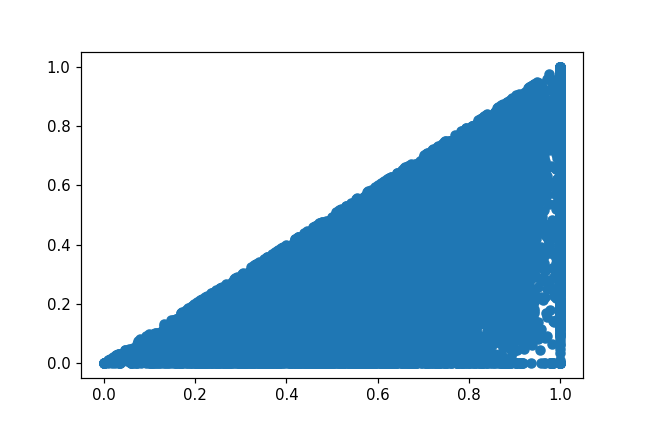

In [678]:
# visual test should be lower triangular
fig, ax = plt.subplots()
ax.scatter(promotion_exposure.promotion_received, promotion_exposure.promotion_viewed)

<IPython.core.display.Javascript object>


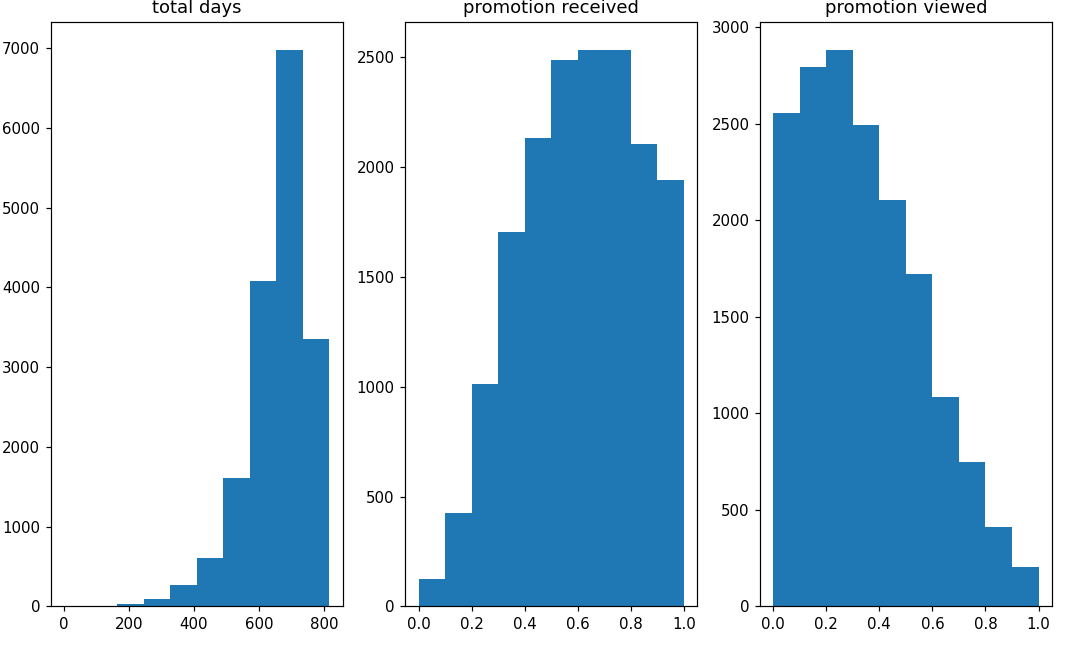

Text(0.5, 1.0, 'promotion viewed')

In [672]:
fig, ax = plt.subplots(1,3, figsize=(10,6))
fig.tight_layout()
ax[0].hist(promotion_exposure.total_days)
ax[0].set_title("total days")
ax[1].hist(promotion_exposure.promotion_received)
ax[1].set_title("promotion received")
ax[2].hist(promotion_exposure.promotion_viewed)
ax[2].set_title("promotion viewed")

In [605]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [330]:
# demographic relationships
with_without = with_offer_sum.join(without_offer_sum, lsuffix='_with', rsuffix='_without')
# 1594 people never bought without a promotion
print(with_without.isna().sum())

value_with                     0
time_with                      0
because_of_offer_with          0
value_without               1594
time_without                1594
because_of_offer_without    1594
dtype: int64


In [331]:
# for people who never bought without a promotion their buying amount without is 0
with_without.fillna(0, inplace=True)

In [333]:
with_without.describe()

,value_with,time_with,because_of_offer_with,value_without,time_without,because_of_offer_without
count,15356.000000,15356.000000,15356.000000,15356.000000,15356.000000,15356.0
mean,44.547497,1795.550794,4.567661,48.907457,1439.675697,0.0
std,37.582440,1376.902726,3.352713,53.431054,1254.473555,0.0
min,0.050000,0.000000,1.000000,0.000000,0.000000,0.0
25%,15.147500,822.000000,2.000000,6.170000,502.500000,0.0
50%,33.610000,1440.000000,4.000000,27.240000,1146.000000,0.0
75%,64.920000,2346.000000,6.000000,79.460000,2070.000000,0.0
max,194.330000,12144.000000,31.000000,245.850000,9408.000000,0.0


In [673]:
id_exposure = promotion_exposure.join(identified, how='inner')

In [674]:
# exclude individuals who don't include demographic infomration
print(id_exposure.shape)
id_exposure.isna().sum()

(14825, 7)


total_days            0
promotion_viewed      0
promotion_received    0
gender                0
age                   0
became_member_on      0
income                0
dtype: int64

In [675]:
id_exposure.describe()

,total_days,promotion_viewed,promotion_received,gender,age,became_member_on,income
count,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,1.482500e+04,14825.000000
mean,651.920944,0.311343,0.590657,0.600877,54.393524,2.016689e+07,65404.991568
std,94.124269,0.209170,0.222273,0.518114,17.383705,1.188565e+04,21598.299410
min,120.000000,0.000000,0.000000,0.000000,18.000000,2.013073e+07,30000.000000
25%,612.000000,0.145161,0.423077,0.000000,42.000000,2.016052e+07,49000.000000
50%,672.000000,0.281818,0.592593,1.000000,55.000000,2.017080e+07,64000.000000
75%,702.000000,0.448980,0.761905,1.000000,66.000000,2.017123e+07,80000.000000
max,816.000000,1.000000,1.000000,2.000000,101.000000,2.018073e+07,120000.000000


In [846]:
complete_person_data = id_exposure.join(with_offer_sum, how='inner')
complete_person_data = complete_person_data.rename({"value": "revenue_with_offer", 
                                                    "because_of_offer": "transactions_with_offer"}, axis=1)
complete_person_data.drop('time', axis=1, inplace=True)
complete_person_data = complete_person_data.join(without_offer_sum, how='inner')
complete_person_data = complete_person_data.rename({"value": "revenue_no_offer"}, axis=1)
complete_person_data.drop(['time', "because_of_offer"], axis=1, inplace=True)

without_offer_count = without_offer.groupby('person').count().drop(["event", "value", "time", "impression_source"], axis=1)
complete_person_data = complete_person_data.join(without_offer_count, how='inner')
complete_person_data = complete_person_data.rename({"because_of_offer": "transactions_no_offer"}, axis=1)
complete_person_data['access_revenue'] = complete_person_data['revenue_with_offer'] - complete_person_data['revenue_no_offer']

In [710]:
complete_person_data.head()

,total_days,promotion_viewed,promotion_received,gender,age,became_member_on,income,revenue_with_offer,transactions_with_offer,revenue_no_offer,transactions_no_offer,access_revenue
2d05ba02bca448b3a9432aa8ff7f4415,696,0.448276,0.517241,1,62,20131124,45000.0,27.13,11,23.32,7,3.81
dbb778dbe0924f56a54aa714406bbcd9,600,0.070000,0.380000,0,73,20170525,99000.0,58.42,3,101.99,4,-43.57
d685d759e77b4795957052e318faf91d,642,0.280374,0.345794,0,55,20171222,92000.0,77.76,4,72.05,3,5.71
aecc4f164b69498fa32aa173636fecbe,582,0.402062,0.422680,1,69,20180424,96000.0,97.32,3,45.07,2,52.25
f7178f6391fc4b698ea2e04bd7ffe512,384,0.593750,0.625000,1,53,20180506,49000.0,13.43,3,3.19,2,10.24


<IPython.core.display.Javascript object>


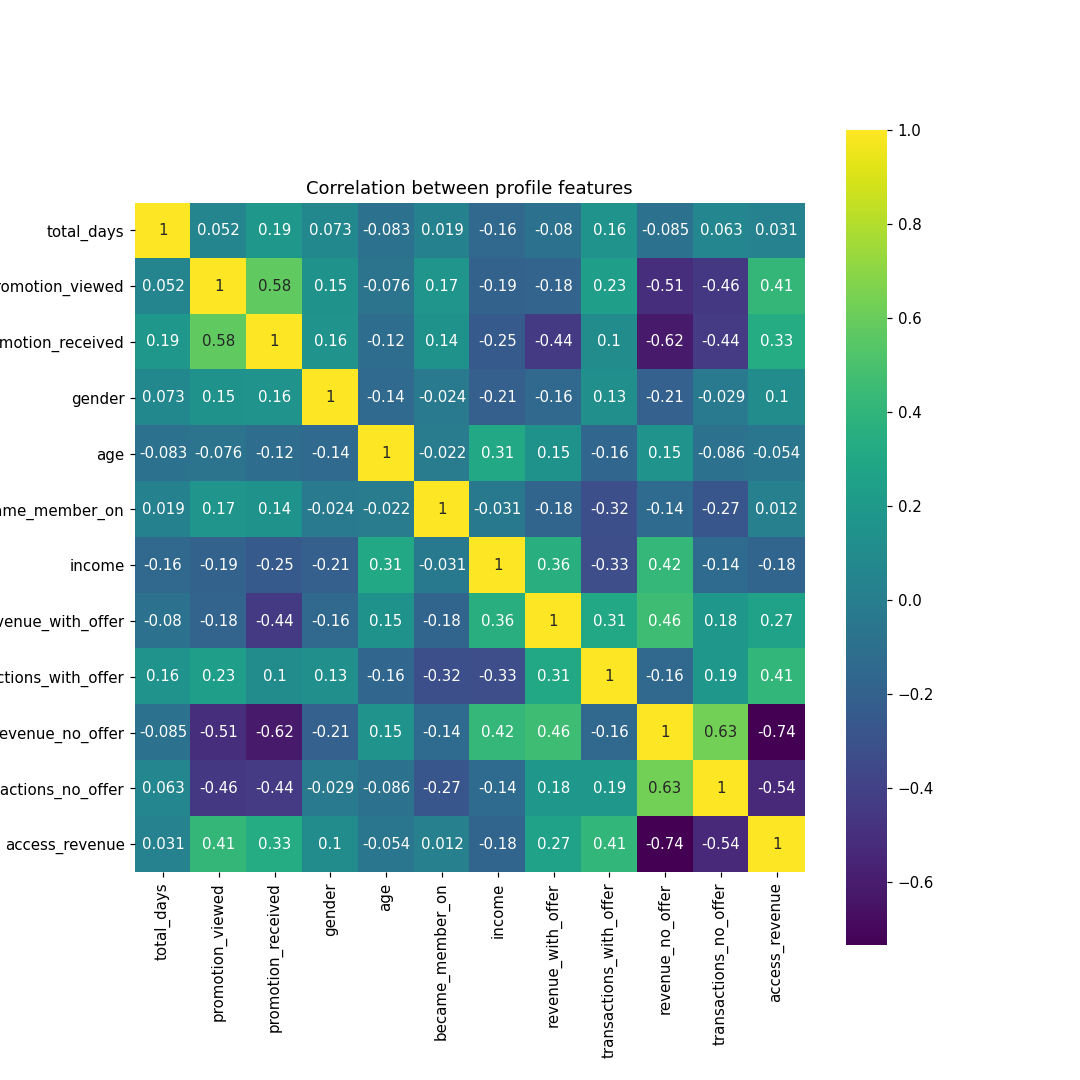

Text(0.5, 1.0, 'Correlation between profile features')

In [712]:

correlation = complete_person_data.corr()
plt.figure(figsize=(10,10))
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='viridis')

plt.title('Correlation between profile features')

In [740]:
people_who_received = complete_person_data[(complete_person_data.promotion_received > 0.5) &
                                          (complete_person_data.revenue_no_offer < 100)]

<IPython.core.display.Javascript object>


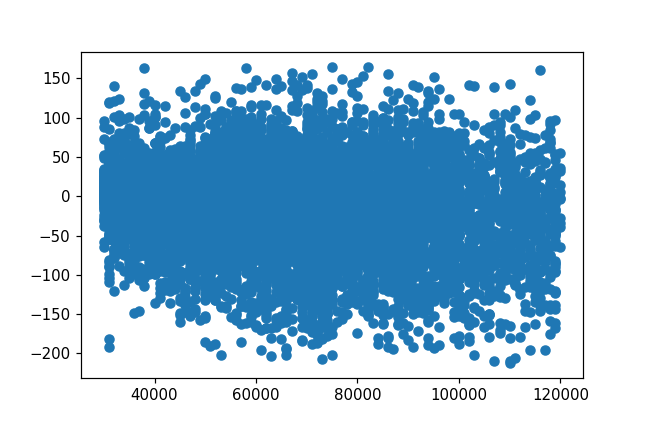

In [719]:
fig, ax = plt.subplots()
ax.scatter(complete_person_data.income, complete_person_data.access_revenue)

In [741]:
people_who_received.sort_values('revenue_no_offer')

,total_days,promotion_viewed,promotion_received,gender,age,became_member_on,income,revenue_with_offer,transactions_with_offer,revenue_no_offer,transactions_no_offer,access_revenue
ab2dfcc6a76844a9a5a37d9d93a74ff7,672,0.276786,0.642857,1,61,20171016,46000.0,5.46,3,0.05,1,5.41
e106cd15296f4145841fdaecde67521b,576,0.552083,0.916667,1,48,20180628,40000.0,6.18,6,0.05,1,6.13
682de3c9fe1a4356978e1b2be4521fdf,672,0.312500,0.732143,0,81,20141108,50000.0,41.76,11,0.05,1,41.71
0f5f04b19ad149eab00dca33360fb8e2,672,0.508929,0.607143,1,34,20180624,37000.0,10.58,6,0.05,1,10.53
a0ece5ddc7014614a12c40d32128c938,648,0.166667,0.666667,1,66,20180125,70000.0,2.04,1,0.05,1,1.99
...,...,...,...,...,...,...,...,...,...,...,...,...
98da26ac30d94be693bc1c0050b73aae,816,0.558824,0.720588,1,45,20180425,93000.0,17.92,1,99.87,5,-81.95
00c2f812f4604c8893152a5c6572030e,582,0.319588,0.556701,0,58,20180630,102000.0,24.21,1,99.88,4,-75.67
8c1a6686814e46e28bd23d8608e12b52,678,0.115044,0.814159,0,64,20170710,69000.0,9.92,1,99.88,6,-89.96
54f9d74bfac742c2bda750340476af30,654,0.504587,0.568807,0,22,20171218,56000.0,69.22,4,99.91,6,-30.69


<IPython.core.display.Javascript object>


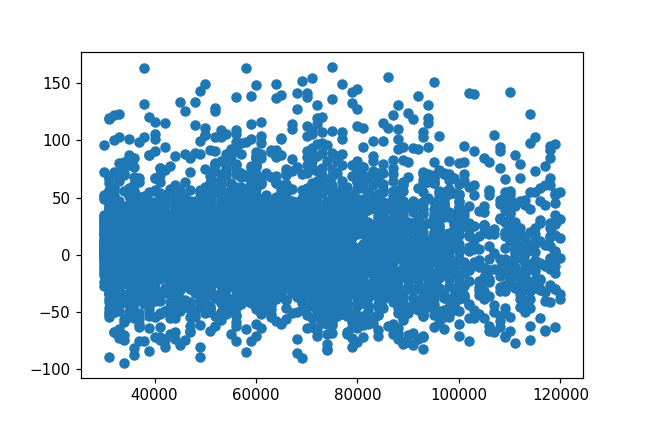

In [742]:
fig, ax = plt.subplots()
ax.scatter(people_who_received.income, people_who_received.access_revenue)

In [743]:
np.corrcoef(people_who_received.income, people_who_received.access_revenue)

array([[ 1.        , -0.00220629],
       [-0.00220629,  1.        ]])

In [745]:
people_who_view = complete_person_data[(
    complete_person_data.promotion_viewed / complete_person_data.promotion_received > 0.5)]

In [756]:
transactions_df.head()

,person,event,value,time,because_of_offer,impression_source
12654,02c083884c7d45b39cc68e1314fec56c,transaction,0.83,0,1,[ae264e3637204a6fb9bb56bc8210ddfd]
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,34.56,0,1,[2906b810c7d4411798c6938adc9daaa5]
12659,54890f68699049c2a04d415abc25e717,transaction,13.23,0,1,[]
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,19.51,0,1,[]
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,18.97,0,1,[]


<IPython.core.display.Javascript object>


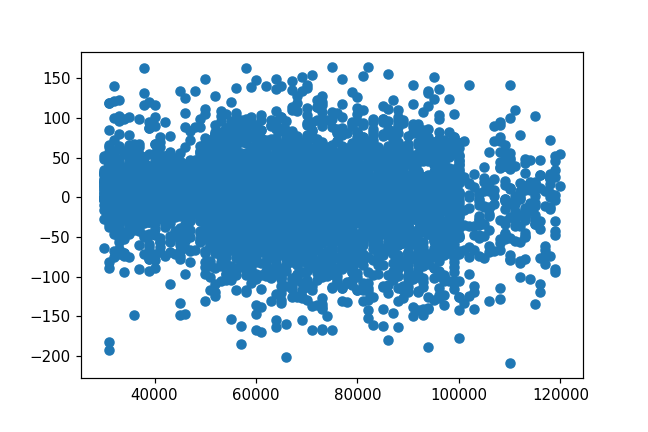

In [746]:
fig, ax = plt.subplots()
ax.scatter(people_who_view.income, people_who_view.access_revenue)

In [783]:
def get_max_outlier(df):
    customer_ids = set(df.person.values)
    max_zscore = {}
    # iterate over all customers and create intervals of received/viewed
    for customer in customer_ids:
        max_zscore[customer] = max(stats.zscore(
            transactions_df.loc[transactions_df.person == customer].value))
    return pd.Series(max_zscore)

In [784]:
zscore_df = get_max_outlier(transactions_df)

In [847]:
zscore_df.name = 'max_zscore_transactions'
complete_person_data = complete_person_data.join(zscore_df, how='inner')

In [794]:
complete_person_data.isna().sum()

total_days                 0
promotion_viewed           0
promotion_received         0
gender                     0
age                        0
became_member_on           0
income                     0
revenue_with_offer         0
transactions_with_offer    0
revenue_no_offer           0
transactions_no_offer      0
access_revenue             0
max_zscore_transactions    0
dtype: int64

In [818]:
people_no_outliers = complete_person_data.loc[(complete_person_data.max_zscore_transactions < 3) &
                                             (complete_person_data.promotion_viewed / complete_person_data.promotion_received > 0.5)]

In [807]:
people_no_outliers.shape

(4459, 13)

<IPython.core.display.Javascript object>


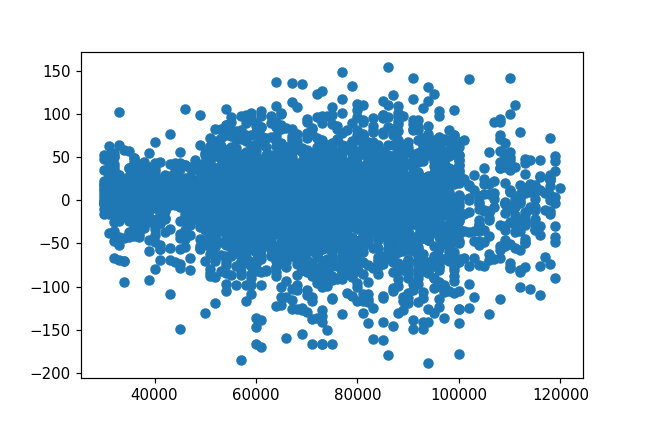

In [813]:
fig, ax = plt.subplots()
ax.scatter(people_no_outliers.income, people_no_outliers.access_revenue)

<IPython.core.display.Javascript object>


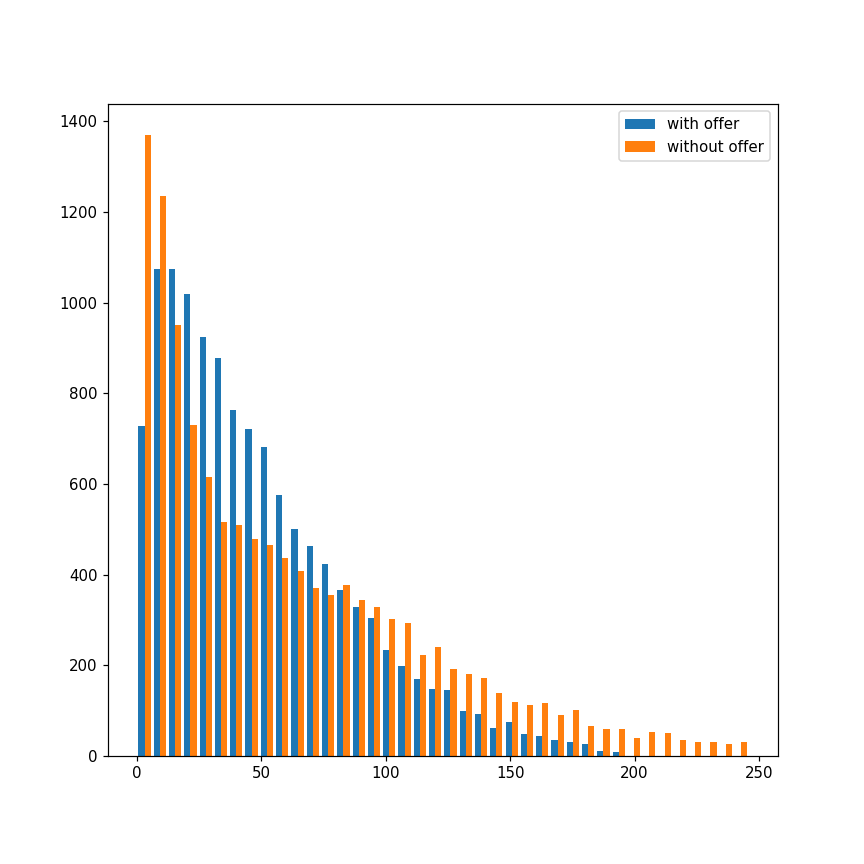

In [825]:
subdf =  complete_person_data
fig, ax = plt.subplots(figsize=(8,8))
ax.hist([subdf.revenue_with_offer, subdf.revenue_no_offer], bins=40, 
        label=['with offer', 'without offer'])
ax.legend()

<IPython.core.display.Javascript object>


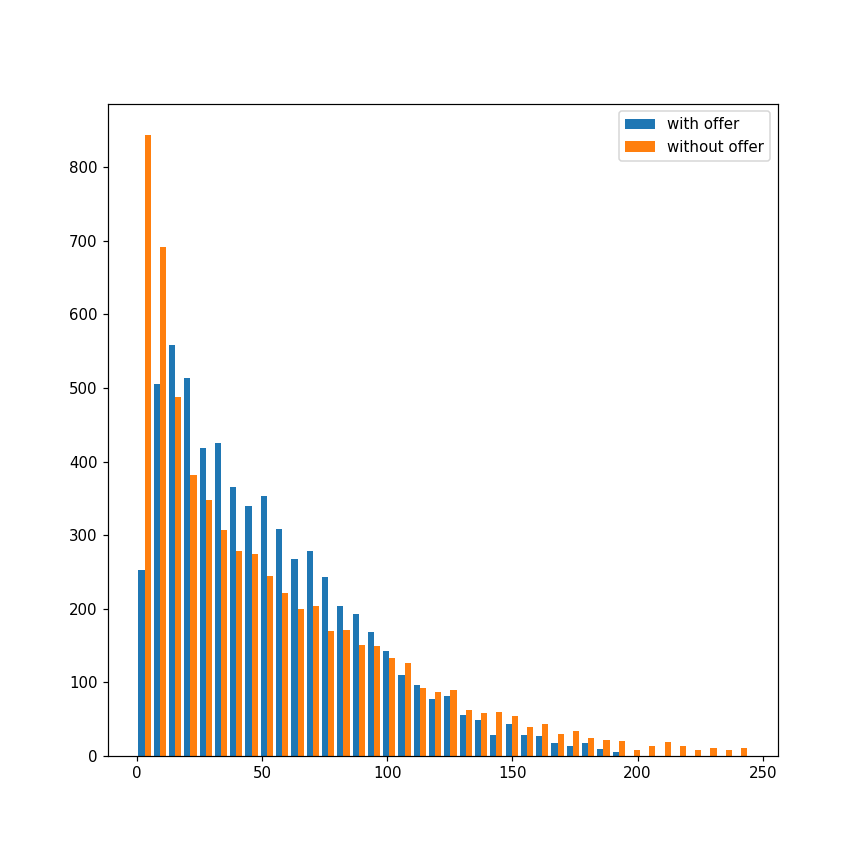

In [819]:
fig, ax = plt.subplots(figsize=(8,8))
ax.hist([people_no_outliers.revenue_with_offer, people_no_outliers.revenue_no_offer], bins=40, 
        label=['with offer', 'without offer'])
ax.legend()

In [827]:
complete_person_data.head()

,total_days,promotion_viewed,promotion_received,gender,age,became_member_on,income,revenue_with_offer,transactions_with_offer,revenue_no_offer,transactions_no_offer,access_revenue,max_zscore_transactions
2d05ba02bca448b3a9432aa8ff7f4415,696,0.448276,0.517241,1,62,20131124,45000.0,27.13,11,23.32,7,3.81,2.399647
dbb778dbe0924f56a54aa714406bbcd9,600,0.070000,0.380000,0,73,20170525,99000.0,58.42,3,101.99,4,-43.57,1.355586
d685d759e77b4795957052e318faf91d,642,0.280374,0.345794,0,55,20171222,92000.0,77.76,4,72.05,3,5.71,1.724384
aecc4f164b69498fa32aa173636fecbe,582,0.402062,0.422680,1,69,20180424,96000.0,97.32,3,45.07,2,52.25,1.274694
f7178f6391fc4b698ea2e04bd7ffe512,384,0.593750,0.625000,1,53,20180506,49000.0,13.43,3,3.19,2,10.24,1.907085


<IPython.core.display.Javascript object>


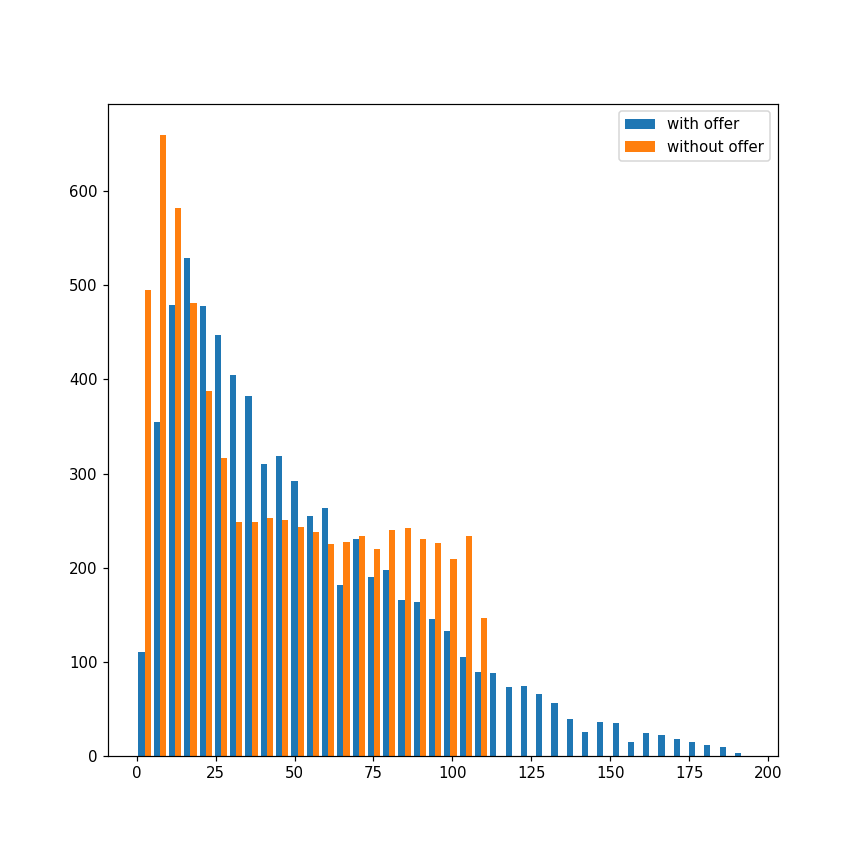

In [835]:
subdf =  complete_person_data.loc[(complete_person_data.revenue_no_offer < 110) & (complete_person_data.transactions_with_offer + complete_person_data.transactions_no_offer > 5)]
fig, ax = plt.subplots(figsize=(8,8))
ax.hist([subdf.revenue_with_offer, subdf.revenue_no_offer], bins=40, 
        label=['with offer', 'without offer'])
ax.legend()

In [850]:
complete_person_data.became_member_on = pd.to_datetime(complete_person_data.became_member_on, format='%Y%m%d')  

In [871]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

scaler = MinMaxScaler()
X = complete_person_data.drop(['access_revenue'], axis=1)
X.became_member_on = X.became_member_on.astype(int)
print(X.dtypes)
X = scaler.fit_transform(X)

pca = PCA(n_components=8)
X = pca.fit_transform(X)
X = pd.DataFrame(X)

label = complete_person_data.access_revenue.apply(lambda x: 1 if x > 5 else 0)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[0], X[1], X[2], s=60, c=label, cmap='Spectral', marker='o')

ax.set_xlabel('PCA Comp 0')
ax.set_ylabel('PCA Comp 1')
ax.set_zlabel('PCA Comp 2')

TypeError: cannot astype a datetimelike from [datetime64[ns]] to [int32]

<IPython.core.display.Javascript object>


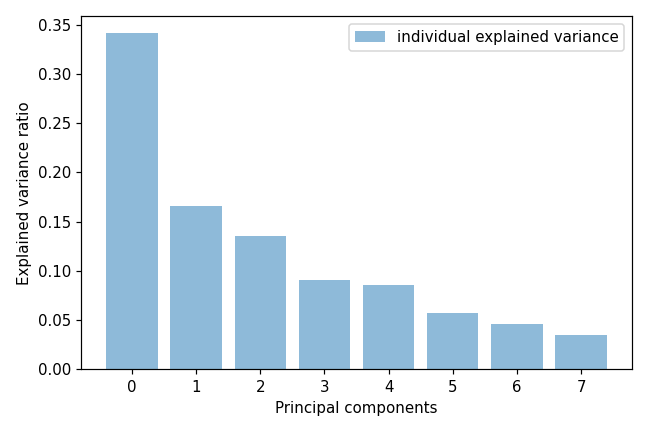

In [869]:
plt.figure(figsize=(6, 4))

plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_, alpha=0.5, align='center', label='individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()

In [840]:
# lets plot and see seperation between access revenue and not

from sklearn.decomposition import PCA
X = complete_person_data.drop(['access_revenue'], axis=1)
pca = PCA(n_components=3)
X = pca.fit_transform(X)
X = pd.DataFrame(X)
print(X)
label = complete_person_data.access_revenue.apply(lambda x: 1 if x > 5 else 0)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(pca[1], pca[2], pca[3], s=60, c=label, cmap='Spectral', marker='o')

ax.set_xlabel('PCA Comp 0')
ax.set_ylabel('PCA Comp 1')
ax.set_zlabel('PCA Comp 2')

                  0             1           2
0     -18756.650069  35245.265163  -34.962101
1      34221.074501  -5520.034517   30.399518
2      27205.531547  -6038.292509   -7.103872
3      30969.579004 -15339.310062   51.118573
4     -16017.149260 -14222.664831  279.511283
...             ...           ...         ...
12246 -10269.339822  15026.299711  166.084720
12247  -1017.672103 -14428.288275   29.474409
12248  -6780.863983  -5072.255545  140.644819
12249    -19.904613 -14527.777928   34.412687
12250 -13755.398573  35231.694722  -27.026505

[12251 rows x 3 columns]


<IPython.core.display.Javascript object>

TypeError: 'PCA' object is not subscriptable

In [276]:
def moments_print(array):
    print("mean = " + str(np.mean(array)))
    print("variance = " + str(np.var(array)))
    print("skew = " + str(stats.skew(array)))
    print("kurtosis = " + str(stats.kurtosis(array))) # fisher kurtosis

In [278]:
print("Total Spent when not in offer")
moments_print(without_offer_mean.value)

Total Spent when not in offer
mean = 12.591535812854586
variance = 90.37223413109649
skew = 0.4844385786873585
kurtosis = -0.6429104452801346
